<a href="https://colab.research.google.com/github/Prichiavellini/the-art-of-command-line/blob/master/Chiavellini_MLpB_I_03_aprendizaje_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning para Bioinformática 2021 - Unidad 1 
## Aplicación de aprendizaje supervisado

Contacto: lbugnon@sinc.unl.edu.ar



## Detección de pre-miRNAs

Identificar potenciales secuencias pre-miRNAs en genomas completos es una tarea desafiante. Estas secuencias se pliegan conformando horquillas, pero no todas las horquillas llegan a ser pre-miRNAs. Muchas de ellas se pueden identificar por alineamiento de secuencias (Blast) con miRNAs conocidos, pero muchas otras pueden tener secuencias diferentes y aún asi conformar pre-miRNAs.   

Mediante un proceso de extracción de características podemos generar variables que describen a estas horquillas, tales como energía libre liberada, cantidad de nucleótidos formando ciertos patrones, etc. Este conjunto de características demostró una gran capacidad discriminativa para este problema. En este caso, el objetivo es que los patrones obtenidos reflejen las posibilidades de la secuencia sin depender de un alineamiento exacto con miRNAs conocidos, y de esta forma encontrar casos no homólogos.

En este ejercicio vamos a comparar diferentes clasificadores para esta tarea. Usaremos un dataset que contiene todas las horquillas de *A. thaliana* con sus características extraídas. Las etiquetas son binarias: 
- clase positiva (1): La secuencia es un pre-miRNA conocido en base a miRBase v21;
- clase negativa (0): La secuencia no tiene una función conocida*. 

Más detalles en [éste artículo](https://www.sciencedirect.com/science/article/pii/S2352340919305633?via%3Dihub)

*Estrictamente la clase negativa es una clase "desconocida", porque no sabemos si puede ser positiva o negativa. Por tanto, es un problema de una clase (y no binario). Sin embargo, se puede plantear como un problema de clasificación binaria si consideramos que la mayoría de las clases desconocidas no serán nunca clase positiva.


## Preparación del dataset
Descargamos los datos del repositorio público y lo cargamos en la notebook

In [13]:
!wget -q --show-progress https://sourceforge.net/projects/sourcesinc/files/mirdata/features/ath.zip/download
!unzip download
!rm download

download            100%[===================>] 185.71M  62.4MB/s    in 3.0s    
Archive:  download
  inflating: ath.csv                 


In [14]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 

data = pd.read_csv("ath.csv")
data

,sequence_names,nt_proportion0,nt_proportion1,nt_proportion2,nt_proportion3,dinucleotide_proportion0,dinucleotide_proportion1,dinucleotide_proportion2,dinucleotide_proportion3,dinucleotide_proportion4,dinucleotide_proportion5,dinucleotide_proportion6,dinucleotide_proportion7,dinucleotide_proportion8,dinucleotide_proportion9,dinucleotide_proportion10,dinucleotide_proportion11,dinucleotide_proportion12,dinucleotide_proportion13,dinucleotide_proportion14,dinucleotide_proportion15,gc_content,gc_ratio,sequence_length,stem_number,avg_bp_stem,longest_stem_length,terminal_loop_length,bp_number,dP,bp_proportion0,bp_proportion1,bp_proportion2,bp_proportion_stem0,bp_proportion_stem1,bp_proportion_stem2,triplets0,triplets1,triplets2,triplets3,triplets4,triplets5,triplets6,triplets7,triplets8,triplets9,triplets10,triplets11,triplets12,triplets13,triplets14,triplets15,triplets16,triplets17,triplets18,triplets19,triplets20,triplets21,triplets22,triplets23,triplets24,triplets25,triplets26,triplets27,triplets28,triplets29,triplets30,triplets31,mfe,efe,ensemble_frequency,diversity,mfe_efe_difference,dQ,dG,mfei1,mfei2,mfei4,CLASS
0,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.257310,0.192982,0.233918,0.315789,0.052941,0.058824,0.082353,0.064706,0.052941,0.023529,0.011765,0.100000,0.064706,0.047059,0.052941,0.070588,0.088235,0.058824,0.088235,0.082353,0.426901,1.212121,171,10,6.700000,13,6,67,0.391813,0.522388,0.373134,0.104478,0.052239,0.037313,0.010448,0.155280,0.124224,0.136646,0.180124,0.018634,0.012422,0.024845,0.049689,0.012422,0.012422,0.012422,0.018634,0.018634,0.000000,0.018634,0.012422,0.037267,0.012422,0.037267,0.024845,0.0,0.0,0.000000,0.0,0.018634,0.018634,0.000000,0.012422,0.000000,0.000000,0.018634,0.012422,-80.0,-81.78,0.055466,8.86,0.010409,0.129659,-0.467836,-1.095890,-0.046784,-1.194030,1
1,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.265306,0.214286,0.204082,0.316327,0.134021,0.041237,0.072165,0.020619,0.030928,0.051546,0.020619,0.103093,0.072165,0.010309,0.072165,0.051546,0.030928,0.113402,0.041237,0.134021,0.418367,0.952381,98,5,8.400000,11,3,42,0.428571,0.523810,0.380952,0.095238,0.104762,0.076190,0.019048,0.153846,0.131868,0.175824,0.197802,0.032967,0.000000,0.032967,0.043956,0.032967,0.032967,0.000000,0.043956,0.000000,0.000000,0.000000,0.000000,0.043956,0.032967,0.010989,0.032967,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53.0,-53.70,0.323430,1.93,0.007143,0.037328,-0.540816,-1.292683,-0.108163,-1.261905,1
2,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.295597,0.182390,0.188679,0.333333,0.101266,0.031646,0.056962,0.107595,0.037975,0.031646,0.025316,0.082278,0.088608,0.018987,0.037975,0.044304,0.063291,0.101266,0.069620,0.101266,0.371069,1.034483,159,8,7.375000,12,3,59,0.371069,0.542373,0.355932,0.101695,0.067797,0.044492,0.012712,0.157895,0.105263,0.111842,0.164474,0.039474,0.026316,0.019737,0.019737,0.026316,0.019737,0.006579,0.013158,0.013158,0.000000,0.000000,0.026316,0.006579,0.000000,0.046053,0.059211,0.0,0.0,0.000000,0.0,0.006579,0.013158,0.006579,0.013158,0.039474,0.013158,0.006579,0.039474,-65.0,-67.09,0.033536,7.47,0.013145,0.117231,-0.408805,-1.101695,-0.051101,-1.101695,1
3,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.375887,0.184397,0.205674,0.234043,0.150000,0.050000,0.042857,0.135714,0.107143,0.021429,0.035714,0.014286,0.057143,0.057143,0.057143,0.035714,0.057143,0.057143,0.071429,0.050000,0.390071,1.115385,141,3,15.000000,21,6,45,0.319149,0.555556,0.400000,0.044444,0.185185,0.133333,0.014815,0.106870,0.091603,0.099237,0.114504,0.038168,0.038168,0.007634,0.045802,0.022901,0.015267,0.007634,0.015267,0.030534,0.000000,0.022901,0.007634,0.030534,0.007634,0.045802,0.038168,0.0,0.0,0.000000,0.0,0.045802,0.000000,0.007634,0.007634,0.076336,0.030534,0.030534,0.015267,-51.8,-53.31,0.086667,13.50,0.010709,0.298322,-0.367376,-0.941818,-0.122459,-1.151111,1
4,1_dna_sm:chromosome_chromosome:TAIR10:1:1:3042...,0.295652,0.182609,0.182609,0.3391

In [15]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.describe()

,nt_proportion0,nt_proportion1,nt_proportion2,nt_proportion3,dinucleotide_proportion0,dinucleotide_proportion1,dinucleotide_proportion2,dinucleotide_proportion3,dinucleotide_proportion4,dinucleotide_proportion5,dinucleotide_proportion6,dinucleotide_proportion7,dinucleotide_proportion8,dinucleotide_proportion9,dinucleotide_proportion10,dinucleotide_proportion11,dinucleotide_proportion12,dinucleotide_proportion13,dinucleotide_proportion14,dinucleotide_proportion15,gc_content,gc_ratio,sequence_length,stem_number,avg_bp_stem,longest_stem_length,terminal_loop_length,bp_number,dP,bp_proportion0,bp_proportion1,bp_proportion2,bp_proportion_stem0,bp_proportion_stem1,bp_proportion_stem2,triplets0,triplets1,triplets2,triplets3,triplets4,triplets5,triplets6,triplets7,triplets8,triplets9,triplets10,triplets11,triplets12,triplets13,triplets14,triplets15,triplets16,triplets17,triplets18,triplets19,triplets20,triplets21,triplets22,triplets23,triplets24,triplets25,triplets26,triplets27,triplets28,triplets29,triplets30,triplets31,mfe,efe,ensemble_frequency,diversity,mfe_efe_difference,dQ,dG,mfei1,mfei2,mfei4,CLASS
count,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00,1355663.00
mean,0.31,0.17,0.18,0.33,0.11,0.05,0.06,0.09,0.06,0.03,0.02,0.06,0.07,0.03,0.03,0.06,0.08,0.06,0.07,0.12,0.35,1.26,82.17,3.25,7.88,7.53,7.73,23.84,0.29,0.54,0.32,0.14,0.19,0.11,0.05,0.12,0.06,0.09,0.15,0.03,0.02,0.02,0.04,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.03,0.02,0.03,0.04,0.00,0.00,0.00,0.00,0.02,0.01,0.01,0.02,0.07,0.03,0.02,0.06,-15.95,-17.50,0.12,11.07,0.02,0.39,-0.20,-0.56,-0.07,-0.67,0.00
std,0.08,0.06,0.06,0.08,0.06,0.03,0.03,0.04,0.03,0.03,0.02,0.03,0.03,0.02,0.03,0.03,0.04,0.03,0.03,0.06,0.09,0.86,16.04,1.08,2.61,2.15,5.50,5.84,0.05,0.13,0.13,0.08,0.09,0.08,0.03,0.05,0.03,0.04,0.05,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.00,0.00,0.01,0.00,0.02,0.01,0.01,0.02,0.06,0.03,0.02,0.05,6.61,6.67,0.11,6.49,0.01,0.22,0.07,0.23,0.04,0.20,0.01
min,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,50.00,1.00,4.00,4.00,3.00,4.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-472.10,-473.32,0.00,0.18,0.00,0.00,-1.01,-43.80,-1.01,-2.21,0.00
25%,0.26,0.13,0.14,0.28,0.07,0.03,0.04,0.06,0.04,0.01,0.00,0.04,0.04,0.01,0.01,0.04,0.05,0.04,0.05,0.08,0.29,0.79,70.00,3.00,6.25,6.00,4.00,20.00,0.26,0.45,0.23,0.08,0.13,0.07,0.03,0.08,0.04,0.07,0.11,0.02,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.00,0.00,0.02,-19.40,-20.99,0.04,6.28,0.01,0.23,-0.24,-0.65,-0.08,-0.80,0.00
50%,0.31,0.17,0.18,0.33,0.10,0.05,0.06,0.09,0.06,0.03,0.02,0.06,0.06,0.03,0.03,0.05,0.07,0.06,0.06,0.11,0.36,1.08,79.00,3.00,7.33,7.00,6.00,23.00,0.29,0.54,0.32,0.13,0.17,0.10,0.04,0.11,0.06,0.09,0.14,0.03,0.02,0.02,0.04,0.01,0.00,0.00,0.01,0.02,0.01,0.00,0.02,0.03,0.01,0.03,0.04,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.02,0.06,0.03,0.01,0.05,-15.10,-16.61,0.09,9.65,0.02,0.35,-0.19,-0.54,-0.06,-0.65,0.00
75%,0.3

In [16]:
data["CLASS"].value_counts()

0    1355359
1        304
Name: CLASS, dtype: int64

Como el desbalaance es muy alto y son muchas horquillas, empezaremos con un caso más manejable, muestreando 5000 ejemplos

In [17]:
n_casos = 5000

# Definimos una probabilidad de muestreo de forma tal que sea mucho mas probable
# muestrear un caso positivo que uno negativo
ratio = sum(data["CLASS"])/len(data)
data["weight"] = data["CLASS"].apply(lambda x: ratio if x==0 else 1)
data = data.sample(n=n_casos, weights=data["weight"])

data["CLASS"].value_counts()

0    4696
1     304
Name: CLASS, dtype: int64

Organizamos los datos en X, y

In [18]:
X = data.drop(columns=["sequence_names", "CLASS", "weight"]).values
y = data["CLASS"].values
print(X.shape, y.shape)

(5000, 77) (5000,)


Haremos una validación cruzada de 5 particiones, las hacemos acá para que todas las pruebas se corran con los mismo datos. Como los datos estan muy desbalanceados, haremos una partición *estratificada*: cada partición tendrá la misma proporción de clases que los datos originales 

In [19]:
from sklearn.model_selection import StratifiedKFold

generador_particiones = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

particiones = list(generador_particiones.split(X, y))

# Ahora "particiones" es una lista de la forma [(train_ind1, test_ind1), (train_ind2, test_ind2), ...]

# Convertimos a una lista para usar la primer parte, pero sino 
# se puede usar así:

# for train_ind, test_ind in generador_particiones.split(X, y):
#   procesamos cada partición  
#   ...
#     


In [20]:
particiones

[(array([   0,    2,    3, ..., 4997, 4998, 4999]),
  array([   1,    9,   17,   18,   21,   30,   32,   34,   35,   38,   42,
           44,   45,   46,   55,   57,   58,   63,   70,   73,   79,   82,
           87,  104,  108,  114,  119,  126,  127,  128,  139,  145,  154,
          164,  166,  171,  172,  174,  179,  183,  184,  190,  196,  202,
          207,  218,  224,  229,  230,  243,  250,  251,  252,  255,  266,
          270,  274,  277,  280,  282,  284,  289,  290,  295,  297,  298,
          303,  308,  312,  316,  318,  324,  327,  336,  343,  346,  351,
          353,  357,  361,  364,  365,  367,  368,  372,  373,  383,  391,
          393,  394,  400,  406,  410,  412,  413,  422,  424,  426,  432,
          435,  451,  468,  479,  482,  489,  490,  504,  515,  521,  526,
          529,  531,  532,  533,  535,  538,  543,  547,  548,  549,  550,
          555,  558,  580,  581,  584,  587,  588,  590,  604,  611,  618,
          619,  620,  634,  636,  640,  644,  65

## Elección de modelos e hiperparámetros 

En esta sección se propone evaluar al menos dos clasificadores diferentes, explorando sus hiperparámetros con la primer partición de entrenamiento. 

Este es un proceso que se puede hacer internamente en la validación cruzada (y de forma automática), pero en este caso lo haremos así para poder analizar los resultados y que el procedimiento no consuma demasiado tiempo.

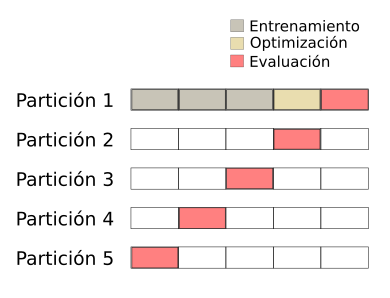

**Importante**: No usar la partición de evaluación para decidir el mejor conjunto 

In [21]:
particiones[0]

(array([   0,    2,    3, ..., 4997, 4998, 4999]),
 array([   1,    9,   17,   18,   21,   30,   32,   34,   35,   38,   42,
          44,   45,   46,   55,   57,   58,   63,   70,   73,   79,   82,
          87,  104,  108,  114,  119,  126,  127,  128,  139,  145,  154,
         164,  166,  171,  172,  174,  179,  183,  184,  190,  196,  202,
         207,  218,  224,  229,  230,  243,  250,  251,  252,  255,  266,
         270,  274,  277,  280,  282,  284,  289,  290,  295,  297,  298,
         303,  308,  312,  316,  318,  324,  327,  336,  343,  346,  351,
         353,  357,  361,  364,  365,  367,  368,  372,  373,  383,  391,
         393,  394,  400,  406,  410,  412,  413,  422,  424,  426,  432,
         435,  451,  468,  479,  482,  489,  490,  504,  515,  521,  526,
         529,  531,  532,  533,  535,  538,  543,  547,  548,  549,  550,
         555,  558,  580,  581,  584,  587,  588,  590,  604,  611,  618,
         619,  620,  634,  636,  640,  644,  654,  665,  666,

In [22]:
from sklearn.model_selection import train_test_split
# definimos la métrica para evaluar los modelos
from sklearn.metrics import f1_score

# Cargamos los datos de la primer partición de entrenamiento, para separarlos 
# en entrenamiento y optimizacion
train_ind, _ = particiones[0] # notar que "test_ind" es "_" porque no lo vamos a usar

# Ahora tendremos las particiones del esquema de arriba 
Xtrain, Xoptim, ytrain, yoptim = train_test_split(X[train_ind, :], y[train_ind], test_size=.2, stratify=y[train_ind])

print("Datos de entrenamiento", Xtrain.shape, "| datos de optimización:", Xoptim.shape)
print(f"Entrenamiento: {len(ytrain)} ({np.sum(ytrain==1)} positivos)")
print(f"Optimización: {len(yoptim)} ({np.sum(yoptim==1)} positivos)")

Datos de entrenamiento (3200, 77) | datos de optimización: (800, 77)
Entrenamiento: 3200 (194 positivos)
Optimización: 800 (49 positivos)


En la siguiente celda hacer la busqueda de hiperparámetros para un modelo

In [23]:
# TODO: Importar la función del clasificador a usar

# TODO completar la lista siguiente con los parámetros a explorar 
param_list = # [...] 
# Si se va a explroar más de un hiperparámetro a la vez, se puede hacer una lista 
# combinando ambos:
# param_list = [(p1, q1), (p2, q2), ...]
# O bien hacer dos ciclos for, uno por cada hiperparámetro

for p in param_list:
    
    # TODO: Instanciar el modelo con el parámetro p
    
    # TODO: Entrenar el modelo

    # TODO: generar una predicción para Xoptim   
    pred = #...
    f1 = f1_score(yoptim, pred)
     
    print("nombre_modelo", p, f1)

SyntaxError: ignored

In [24]:
#Funcion del clasificador MLP a usar
from sklearn.neural_network import MLPClassifier

modelo = MLPClassifier() 
print("Hiperparámetros del modelo MLP:\n")
print(modelo.get_params())  #estos son todos los parametros del modelo Multicapa



Hiperparámetros del modelo:

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [61]:
#Parametros a explorar
print("Los parametros a explorar son hidden layer sizes (100 y 200)y Activation function (relu:rectified linear unit function y tanh:hyperbolic tan function), en las 4 combinaciones")
param_list= [(10,"relu"),(100,"relu"),(10,"tanh"),(100,"tanh")]
print("Param_list=",param_list)

Los parametros a explorar son hidden layer sizes (100 y 200)y Activation function (relu:rectified linear unit function y tanh:hyperbolic tan function), en las 4 combinaciones
Param_list= [(10, 'relu'), (100, 'relu'), (10, 'tanh'), (100, 'tanh')]


In [63]:
print("MLP")
print("hidden layer size","Activation_f","f1")
for p,q in param_list:
  modelo=MLPClassifier(hidden_layer_sizes=p,activation=q, max_iter=300)
  modelo.fit(Xtrain,ytrain)
  pred=modelo.predict(Xoptim)
  f1=f1_score(yoptim,pred)
  print(p,q,f1)

MLP
hidden layer size Activation_f f1
        10 relu 0.75
        100 relu 0.7710843373493975
        10 tanh 0.7407407407407408
        100 tanh 0.7407407407407408


In [64]:
#MODELO SVM
from sklearn.svm import SVC
modelo2=SVC()
print("Hiperparámetros del modelo SVM:\n")
print(modelo2.get_params())  #estos son todos los parametros del modelo Multicapa


Hiperparámetros del modelo SVM:

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [82]:
#Los parametros a explorar son el c y el gamma en un modelo con kernel rbf
c=(0.1,10,100)
g=(0.1,"scale",1,100)

In [94]:
print("SVM")
print("C","Gamma","f1")
for p in c:
  for q in g:
    modelo2=SVC(C=p,kernel="rbf",gamma=q, probability=True)
    modelo2.fit(Xtrain,ytrain)
    pred=modelo2.predict(Xoptim)
    f1=f1_score(yoptim,pred)
    print(p,q,f1)

SVM
C Gamma f1
0.1 0.1 0.0
0.1 scale 0.48484848484848486
0.1 1 0.0
0.1 100 0.0
10 0.1 0.1481481481481481
10 scale 0.6301369863013699
10 1 0.07843137254901959
10 100 0.07843137254901959
100 0.1 0.1481481481481481
100 scale 0.6666666666666667
100 1 0.07843137254901959
100 100 0.07843137254901959


In [ ]:
#Parámetros óptimos para el modelo MLP  hidden layers= 100, activation =relu.
#Parámetros óptimos para el modelo SVM c= 100, gamma= scale.

Repetir la celda anterior para cada modelo a evaluar

## Validación cruzada

A partir del análisis anterior tendremos un conjunto de parámetros óptimo para cada modelo. Como el objetivo es comparar clasificadores, ahora haremos la validación cruzada para tener una estimación insesgada del funcionamiento de cada clasificador en este dataset. 

In [91]:
# TQDM muestra una barra de avance a medida que pasan las iteraciones 
from tqdm import tqdm

# Vamos a analizar varias métricas
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

results = []

for train_ind, test_ind in tqdm(particiones): 
    for nombre_modelo in ["MLP", "SVC"]: # TODO completar con todos los modelos a usar
            
        if nombre_modelo == "MLP":
            # TODO: instanciar el modelo con los hiperparámetros que dieron mejor en el análisis previo
            modelo = MLPClassifier(hidden_layer_sizes=100,activation="relu", max_iter=300)
        if nombre_modelo == "SVC":
            # TODO: instanciar el modelo con los hiperparámetros que dieron mejor en el análisis previo
            modelo = SVC(C=100,kernel="rbf",gamma="scale", probability=True)

        # notar que ahora X[train_ind, :] contiene a Xtrain y Xoptim del punto 
        # anterior
        modelo.fit(X[train_ind, :], y[train_ind])

        # La siguietne predicción se hace sobre datos que no fueron vistos antes
        pred = modelo.predict(X[test_ind, :])

        results.append([nombre_modelo,
                        accuracy_score(y[test_ind], pred),
                       f1_score(y[test_ind], pred),
                       recall_score(y[test_ind], pred),
                       precision_score(y[test_ind], pred)])

results = pd.DataFrame(results, columns=["modelo", "acc", "f1", "pre", "rec"])
results

100%|██████████| 5/5 [00:25<00:00,  5.04s/it]


,modelo,acc,f1,pre,rec
0,MLP,0.97,0.73,0.61,0.90
1,SVC,0.97,0.69,0.56,0.92
2,MLP,0.98,0.80,0.67,0.98
3,SVC,0.98,0.81,0.69,0.98
4,MLP,0.98,0.77,0.62,1.00
5,SVC,0.97,0.75,0.61,0.97
6,MLP,0.97,0.69,0.59,0.82
7,SVC,0.97,0.68,0.56,0.87
8,MLP,0.97,0.70,0.55,0.97
9,SVC,0.97,0.68,0.53,0.94


## Comparación final
Con la lista de resultados podemos comparar los modelos en términos de las diferentes métricas de error

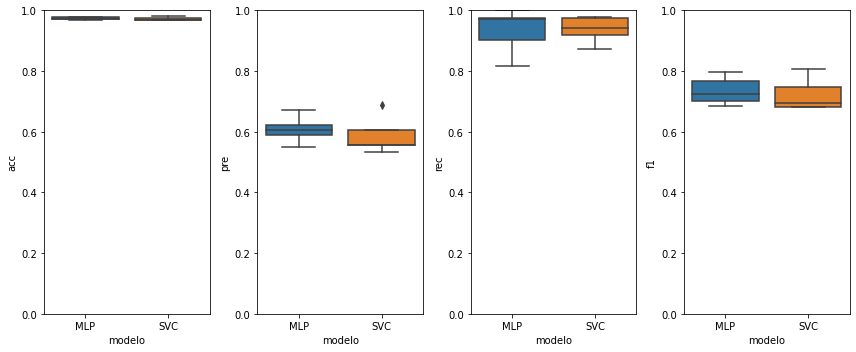

In [92]:
import seaborn

fig, ax = plt.subplots(1, 4, figsize=(12, 5))

for k, metric in enumerate(["acc", "pre", "rec", "f1"]):
    seaborn.boxplot(data=results, y=metric, x="modelo", ax=ax[k])
    ax[k].set_ylim([0, 1])
plt.tight_layout()

In [ ]:
#La acc es similar, cercana al uno, mayor a 0.97. Quizas el parametro mas importante para mirar en este estudio es el recall, la "habilidad" de encontrar todos los positivos
#ya que probablemente sea mas importante "identificarlos" primero y luego estudiarlos y confirmar que actúen como miRNAs. En este sentido el recall
#es mas variable cuando se evalua utilizando el modelo MLP que con SVC.

Además de las métricas puntuales, podemos analizar las predicciones modelo en términos de su curva precisión-recall. 

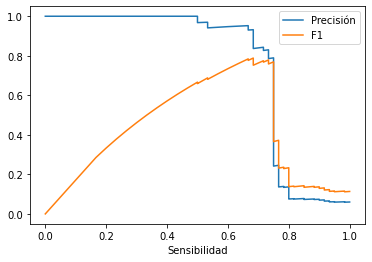

In [93]:
from sklearn.metrics import precision_recall_curve

# En este caso graficamos solo el último modelo evaluado sobre la 
# última partición de prueba

scores = modelo.predict_proba(X[test_ind, :])

pre, rec, th = precision_recall_curve(y[test_ind], scores[:, 1])

f1 = 2*pre*rec / (pre+rec)
plt.plot(rec, pre, label="Precisión")
plt.plot(rec, f1, label="F1")
plt.xlabel("Sensibilidad")
plt.legend();

# Otras aplicaciones de aprendizaje supervisado

Te proponemos ahora pensar en tu propia área de aplicación. 
- ¿En qué podrías aplicar modelos de ML para clasificación o regresión? 
- ¿Tenés datos disponibles? o, ¿de donde los obtendrías?
- ¿Crees que sería necesario una etapa adicional de acondicionamiento de los datos?